### Projeto Final Modelo Preditivo ###

***Para Não Esqueçer***



Limpeza e Tratamento de Valores Nulos (até 0,5 pt):


A qualidade dos dados é crucial. Demonstre seu processo de limpeza, incluindo a maneira como lida com valores ausentes e outliers que possam distorcer os resultados.


Codificação de Variáveis Categóricas (até 0,5 pt):


Aplique técnicas apropriadas de codificação para transformar variáveis categóricas em formatos utilizáveis em modelos preditivos, garantindo que a informação essencial não seja perdida no processo.


Exploração e Visualização dos Dados (até 2,0 pts):


Realize uma análise exploratória detalhada para descobrir padrões, correlações e tendências nos dados. Use visualizações eficazes para comunicar seus insights e justificar suas escolhas de features e modelos.


Formulação de Hipóteses (até 1,0 pt):


Formule três hipóteses que possam explicar os fatores que influenciam o sucesso da empresas. Por exemplo, pode-se investigar se a empresas com mais funcionários ou com menos tempo de fundação têm maior chance de sucesso.


Seleção de Features (até 1,0 pt):


Escolha as features mais relevantes para o modelo com base em sua análise exploratória e hipóteses formuladas.


Construção e Avaliação do Modelo (até 2,0 pts):


Selecione um modelo de machine learning adequado (ou uma combinação de modelos) que maximize a capacidade preditiva. A avaliação deve incluir métricas como acurácia, precisão, recall, e F1-score.
Finetuning de Hiperparâmetros (até 1,0 pt):


Realize um ajuste fino (finetuning) dos hiperparâmetros do modelo para otimizar seu desempenho. Detalhe o processo de busca e as justificativas para as escolhas feitas.


Acurácia Mínima (até 2,0 pts):


O modelo deve atingir uma acurácia mínima de 80% para ser considerado bem-sucedido (pontuação total ao final do campeonato). Embora a acurácia seja a métrica principal usada na competição, analise também outras métricas como precisão e recall, para melhor interpretação do desempenho do modelo preditivo treinado.


Documentação e Apresentação dos Resultados (demérito de até 2,0 pts):


A documentação clara e a apresentação dos resultados são importantes. O notebook final deve ser bem organizado, com código limpo, e o raciocínio por trás de cada decisão deve ser explicado de forma objetiva e compreensível em células de texto, sem exageros.


In [1]:
#Importação das bibliotecas Visuais e ultilizadoras de dados
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
# PImportação das bibliotecas necessarias para pre-processamento, Treino e resultados dos modelos
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

sns.set_theme()
ID_COL = 'id' # Colunas para identificação
TARGET_COL = 'labels' # Labels de previsão
RANDOM_STATE = 42 # Sempre fixado em 42


In [2]:
import os, pandas as pd

# Caminhos para rodar em vscode/kaggle
if os.path.exists('/kaggle/input'):
    DATA_DIR = '/kaggle/input/<NOME-DO-DATASET-NO-KAGGLE>'  
else:
    DATA_DIR = 'Dataset'  

TRAIN_PATH  = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH   = os.path.join(DATA_DIR, 'test.csv')
SAMPLE_PATH = os.path.join(DATA_DIR, 'sample_submission.csv')

train  = pd.read_csv(TRAIN_PATH) # Csv de treino
test   = pd.read_csv(TEST_PATH) # Csv de teste
sample = pd.read_csv(SAMPLE_PATH) # Csv de submissão

assert ID_COL in train.columns and ID_COL in test.columns
assert TARGET_COL in train.columns and TARGET_COL not in test.columns

# Imprime as primeiras 5 linhas do dataset de treino
print('shapes:', train.shape, test.shape)
train.head()


shapes: (646, 33) (277, 32)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


### Pré Processamento/Diagnostico ###

Nessa etapa, eu comecei a explorar mais a  qualidade do dataset. Primeiro mostrei algumas colunas com mais  valores nulos, para entender qual seri o nivel da limpeza para ver futuramente se usuaria um drop ou algo do tipo para limpeza de fato. Outro motivo pelo qual optei por não realizar nenhuma limpeza agora, seria pra evitar qualquer tipo de vazamento, ou entrega de reusltado para meu modelo final. Depois verifiquei o nivel da distribuição da variável alvo, para ver se estavam balanceadas ou não. Também já separei as colunas em numéricas e categóricas, pra facilitar o pre processamento. 

In [3]:
# Mostra as 10 colunas com mais nulos
print('Nulos (top 10):')
print(train.isnull().sum().sort_values(ascending=False).head(10))

print('\nDistribuição do alvo:')
print(train[TARGET_COL].value_counts(normalize=True))

# separação colunas numéricas e categóricas
num_cols = [c for c in train.columns if c not in (ID_COL, TARGET_COL) and pd.api.types.is_numeric_dtype(train[c])]
cat_cols = [c for c in train.columns if c not in (ID_COL, TARGET_COL) and not pd.api.types.is_numeric_dtype(train[c])]
print(f'num_cols: {len(num_cols)} | cat_cols: {len(cat_cols)}')



Nulos (top 10):
age_first_milestone_year    138
age_last_milestone_year     111
age_first_funding_year       35
age_last_funding_year         9
id                            0
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
dtype: int64

Distribuição do alvo:
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64
num_cols: 30 | cat_cols: 1


### Geração dos Graficos/Histogramas ###

Em seguida, plotei histogramas de algumas variáveis importantes geradas na celula passada, como funding_total_usd, milestones, relationships e funding_rounds, para ver de primiera se ja era possivel identificar algum outliers. Por fim, montei uma matriz "base" de correlação para conseguir identificar as relação entre as minhas features ultilizadas.

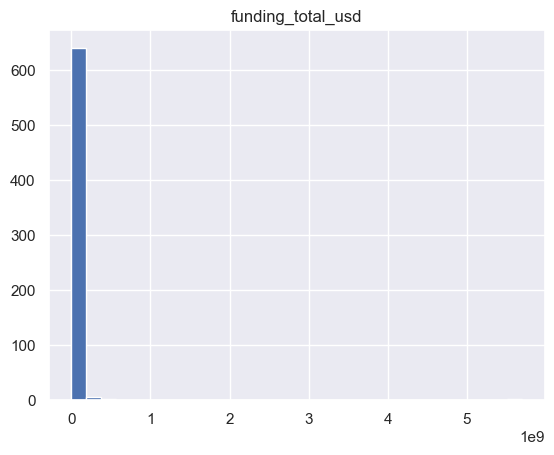

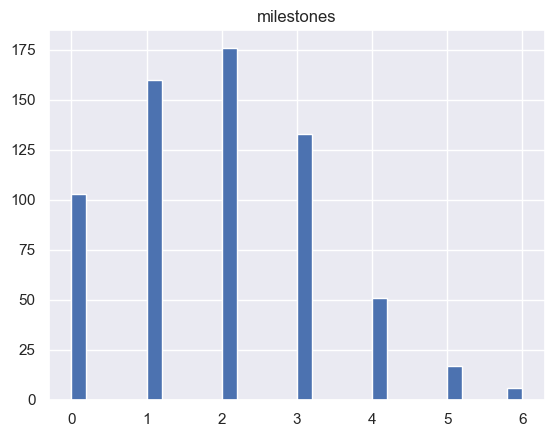

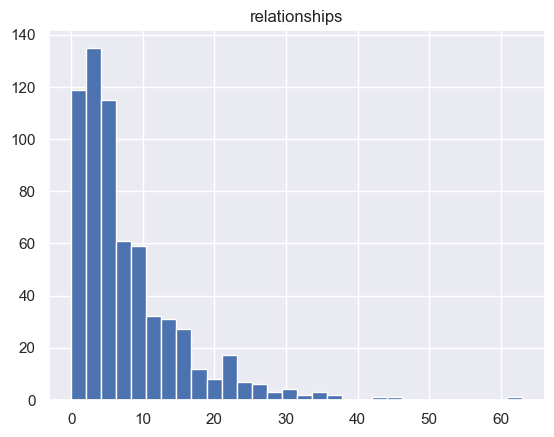

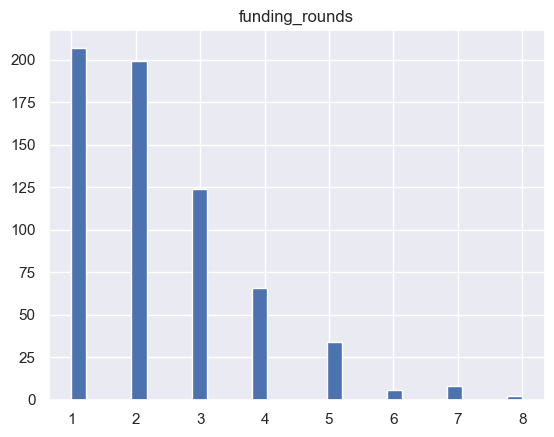

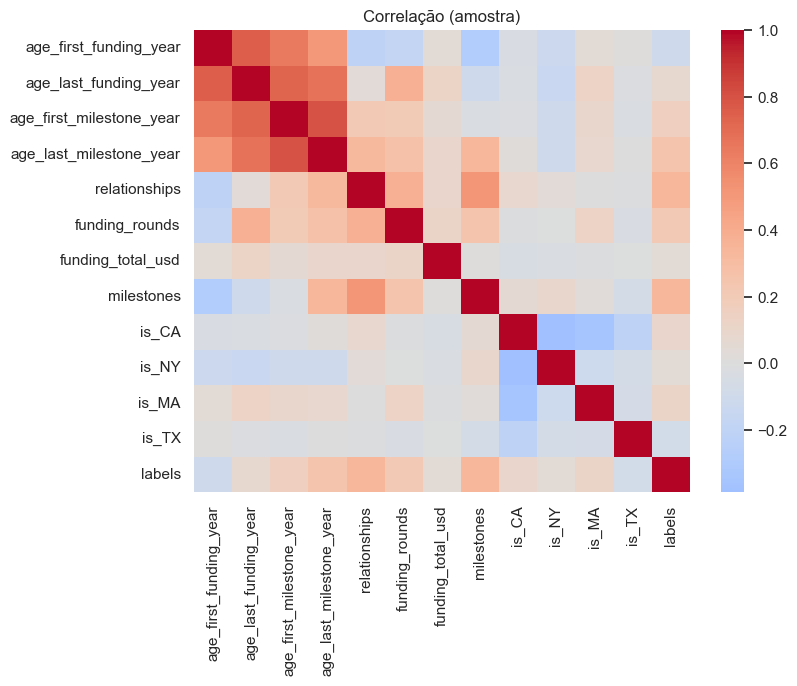

In [4]:
# histogramas de capital levantado pelas startups, e marcos alcançados
for c in [x for x in ['funding_total_usd','milestones','relationships','funding_rounds'] if x in num_cols]:
    plt.figure(); plt.hist(train[c].dropna(), bins=30); plt.title(c); plt.show()

# Matrz de correlção entre as features ultilizadas
subset = num_cols[:12]
if len(subset) >= 2:
    corr = train[subset + [TARGET_COL]].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Correlação (amostra)'); plt.show()

### Resultados ###

### Hipoteses ###

Nessa parte começei a formular minhas hipoteses. Primeiro, comparei as startups com funding acima e abaixo da mediana, para assim verificar se o nível de investimento poderia influenciar no resultado final. Com isso formulei minha 

***H1: "Empresas com maior funding tem melhores resultados."***

Depois, fiz a mesma comparação usando o número de milestones que são marcos/metas das empresas, e analisar se estiverem acima ou abaixo da mediana tambem influenciavam o resultado/performamce da empresa de alguma forma. Com isso formulei minha

 ***H2: "Empresas que atigiram milestones acima da mediana tem maiores chances de sucesso."*** 

Por fim, observei a taxa de sucesso das startups por lacalização, e assim formulei minha

 ***H3: " Startups localizadas nos principais Hubs de Inovação (CA, NY, MA e TX) tendem a ter mais sucesso."***

 Agora você leitor deve estar se perguntando o porque da minha escolha de comprar minhas feauteres com a mediana das startups nas minhas hipoteses e não com a média. Optei pela comparação com a mediana,  em vez da média pelo simples fato de ser menos  sensível a outlieres. Como algumas startups levantam quantias muito altas de capital em relaçãoa a outras, a média ficaria distorcida, ja que uma startup em especifico jogaria muito pro alto enquanto essa não é a realidade em uma comparçaõ justa, enquanto isso a mediana  consegue achar um ponto de equilíbrio de todas as startups.

In [5]:
# Define y como variavel alvo
y = train[TARGET_COL]

def taxa(col, cond):
    return train.loc[cond, TARGET_COL].mean()

# H1: Startups com funding acima ou abaixo da mediana
thr = train['funding_total_usd'].median()
print('Funding alto:', taxa('funding_total_usd', train['funding_total_usd'] >= thr))
print('Funding baixo:', taxa('funding_total_usd', train['funding_total_usd'] < thr))

# H2: Startups com metas alcançadas acima ou abaixo da mediana
thr = train['milestones'].median()
print('Milestones alto:', taxa('milestones', train['milestones'] >= thr))
print('Milestones baixo:', taxa('milestones', train['milestones'] < thr))

# H3: localização  das startups
for col in ['is_CA','is_NY','is_MA','is_TX']:
    if col in train.columns:
        print(col, '->', train.groupby(col)[TARGET_COL].mean())


Funding alto: 0.7461300309597523
Funding baixo: 0.5479876160990712
Milestones alto: 0.7676240208877284
Milestones baixo: 0.4714828897338403
is_CA -> is_CA
0    0.593857
1    0.691218
Name: labels, dtype: float64
is_NY -> is_NY
0    0.640000
1    0.704225
Name: labels, dtype: float64
is_MA -> is_MA
0    0.629060
1    0.819672
Name: labels, dtype: float64
is_TX -> is_TX
0    0.654341
1    0.458333
Name: labels, dtype: float64


### Resultados ###


Agora com os resultados da celula anterior é possivel analisar e comparar a acertividade das minhas hipoteses. Começando com H1 do funding, as startups com valores acima da mediana apresentaram taxa de sucesso de aproximadamente  de ***74,6%***, contra apenas ***54,7%*** das outras que receberam menos investimento. Isso confirma minha H1 que foi "Empresas com maior funding tem melhores resultados."

Ja em relação a minha H2, os resultados mostraram uma diferença ainda maior. As startups com mais marcos do que a mediana tiveram taxa de sucesso de aproximadamente de ***76,7%***, enquanto o resto ficou por volta ***47%***. Esse resultado confirmou minha H2 que foi: "Empresas que atigiram milestones acima da mediana tem maiores chances de sucesso."

Ja na minha H3 ha acertos e erros, em relação a tendencia da localização gerar melhor performance nas empresas. Começando por  Startups na Califórnia (CA) tiveram uma taxa de sucesso maior de ***69%*** em relção do restante ***59,3%***, em Nova Iorque (Ny)  isso tambem se confirmou com média de aprox ***70%*** contra ***64%*** do restante. Ja em Massachusetts (MA) houve a diferença mais expressiva quase ***82%*** na taxa de sucesso contra ***62,9%*** do restante. Por fim, Texas (TX) foi a unica localização na qual minha tese não se confirmou, no qual  a taxa de sucesso ficou em apenas ***45,8%***. Por fim é notorio que grande parte da minha H3 foi confrimada, e a apenas um estado entre os principais teve performance de sucesso abaixo o que pode indicar um ponto fora da curva mesmo.



### Pré Processamento 2 ###


Nessa parte começei a fazer um pré processamento mais avançado. Aqui eu começei separando as variáveis independentes (X) da variável alvo (y) e preparei também um conjunto de teste. 
Também voltei a separar as colunas numéricas e categóricas.

Para as variáveis numéricas, defini um pipeline para preencher os valores nulos com a mediana e depois padronizar-los  para que fiquem na mesma escala usando o `StandardScaler`. Já para as variáveis preenchi os valores nulos com a moda e depois transformei cada categoria em colunas binárias através do One-Hot Encoding. Ao final, com  Esses dois pipelines fiz uma junção  em um  unico `ColumnTransformer`, que garante que cada etapa seja aplicada corretamente em cada grupo de colunas.  

Por fim, dividi os dados em treino e validação (80 treino/20 validação), estratificando a variável alvo para manter a proporção entre as classes. Com essa divisão eu consigo treinar com eficacia e deixar que tenha vazamento de informação entre o treino o teste assim deixando o modelo mais rwalista na avaliação.



In [6]:
# Separar features (X) e target (y)
X = train.drop(columns=[TARGET_COL]) # todas colunas menos a alvo
y = train[TARGET_COL] # coluna alvo
X_test = test.copy() # conjunto de teste

# Identificar colunas numéricas e categóricas e exclui ID
num_cols = [c for c in X.columns if c != ID_COL and pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c != ID_COL and not pd.api.types.is_numeric_dtype(X[c])]

print(f"Colunas numéricas: {len(num_cols)} | Colunas categóricas: {len(cat_cols)}")

# Pipelines para categorias numericas
# Imputação com mediana nos valores nulos + padronização com standartscaler
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

# Pipelines para categorias categóricas
# Imputação com moda nos valores nulos
# onehotencoder para transformar em colunas binárias
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))

])

# ColumnTransformer unindo tudo
preprocess = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
], remainder='drop')

# Split treino/validação 80/20
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train.shape, X_valid.shape, y_train.mean(), y_valid.mean()


Colunas numéricas: 30 | Colunas categóricas: 1


((516, 32),
 (130, 32),
 np.float64(0.6472868217054264),
 np.float64(0.6461538461538462))

### Modelo Random Forest ###

Agora com toda base ja ajustada, fiz meu modelo de random forest completo. Eu optei pela escolha do modelo de random forest pois pelas regras que não podiam modelos de regressão ou uso de XGBOOST acredito que o random forest é com maior diversificação para chegar a uma acurácia minima de 80%. Isso se da pelo fato que o Random já um modelo que lida com menos overfitting e vises ja que diferentememte da arvore de desição normal, ele cria diversas arvores que usam parte do dataset realiznado a media de cada arvore e assim chegando a uma previsão. Tambem é um modelo que é possivel ajustar bem hisperparametros como limitação de criação de arvores ou escolher a profundiade de cada arvore, foi possoivel ajustar diversas vezes até chegar a acurácia necessaria.

Primeiramente preparei funções auxiliares para localizar os arquivos de treino e teste e identificar automaticamente as colunas ID e target. Agora entramos na parte de limpeza do dataset que foi minima, apenas  removi algumas duplicatas, tambem retirei colunas que poderiam gerar vazamento de informação e o resultado entregue pro modelo como "status" e "outcome" e denovo seprai  as  minhas features entre numéricas e categóricas.

Realizei novamnete uma imputação da mediana nos valores numericos. E  apliquei também PolynomialFeatures que foi uma recomendação de uma integrante do meu grupo de trabalho, para gerar melhores interações entre  as minhas variáveis. Já nas categóricas, fiz o mesmo da celula passada ultilizei a moda junto com hotencoder.

Começei a definir hiperparâmetros base para o Random Forest, como número de árvores (n_estimators=1200), pedaços de variáveis consideradas em cada divisão (max_features=0.3), tamanho mínimo das folhas e divisões, além de testar diferentes profundidades das árvores (14, 18, 22 e ilimitada). Toda essa parte foi feita apartir de ajustes em todos hiperparametros até chegar na acuracia ideal no kaggle. O resultado do codigo foi essencial pra eu conseguir saber onde eu tinha qu eajustar os paraemetros pra chegar na melhor acurácia.

Apos ajustar os hiperparâmetros, fiz a validação usando 5 divisões do conjunto de dados  (StratifiedKFold). Em cada divisão, testei o modelo e calculei as previsões para os dados que ficaram de fora. Com esses resultados, consegui avaliar a acurácia em diferentes pontos de corte (thresholds) e escolhi o que trouxe o melhor desempenho. Depois apenas peguei os melhores resutados e treinei o modelo inteiro de uma vez.

Por fim, cirei um csv com as colunas id e labels para conseguir entregar no kaggle e ver minha acuracia na plataforma.

In [7]:

import numpy as np, pandas as pd, warnings, os, re
from pathlib import Path
warnings.filterwarnings("ignore")

#  faz busca dos arquivos no padrão kaggle e vscode
def _find_files(names_or_regex, roots=(Path('.'), Path('/kaggle/input'))):
    cand, seen = [], set()
    pats = [re.compile(p) for p in (names_or_regex if isinstance(names_or_regex,(list,tuple)) else [names_or_regex])]
    for root in roots:
        if not root.exists(): 
            continue
        for dp,_,fs in os.walk(root):
            for fn in fs:
                for pat in pats:
                    if pat.fullmatch(fn) or pat.search(fn):
                        p = Path(dp)/fn
                        if p not in seen:
                            cand.append(p); seen.add(p)
    return cand

# descobre automaticamente  a coluna id e alvo
def _detect_cols(train, test):
    COMMON_TARGETS = ['labels','label','target','Survived','y']
    TARGET_COL = next((c for c in COMMON_TARGETS if c in train.columns and c not in test.columns), 'labels')
    shared = [c for c in train.columns if c in test.columns]
    ID_COL = 'id' if 'id' in shared else (shared[0] if shared else 'id')
    return TARGET_COL, ID_COL

# carrega treino e teste se nao tiver na memoria
if 'train' not in globals() or 'test' not in globals():
    tps = _find_files([r'^train\.csv$', r'train.*\.csv'])
    vps = _find_files([r'^test\.csv$',  r'test.*\.csv'])
    assert tps and vps, "Coloque train/test no diretório ou carregue em memória."
    train = pd.read_csv(sorted(tps, key=lambda p: len(str(p)))[0])
    test  = pd.read_csv(sorted(vps, key=lambda p: len(str(p)))[0])

# faz a leitura do sample submisson csv para colunas e linhas
sample = globals().get('sample', None)
if sample is None:
    for p in [Path('sample_submission.csv'), Path('/kaggle/input/sample_submission.csv')]:
        if p.exists():
            try: sample = pd.read_csv(p); break
            except: pass

# função de adicionar features extras opcionalmente
if 'add_features' not in globals():
    def add_features(df): return df.copy()

# detecta colunas alvo e id e garantem sua existencia
TARGET_COL, ID_COL = _detect_cols(train, test)
assert TARGET_COL in train.columns, f"TARGET_COL '{TARGET_COL}' não está no train."
assert ID_COL in test.columns, f"ID_COL '{ID_COL}' não está no test."

# adiciona features extras
train_fe = add_features(train).copy()
test_fe  = add_features(test).copy()

# remove as colunas duplicadas (se houver) se nao tiver ignorar
if ID_COL in train_fe: train_fe = train_fe.drop_duplicates(subset=[ID_COL], keep='last').reset_index(drop=True)
if ID_COL in test_fe:  test_fe  = test_fe.drop_duplicates(subset=[ID_COL], keep='last').reset_index(drop=True)

# Limpeza minima
# remove colunas propicias de vazamento
LEAKY = [c for c in ['status','closed_at','is_acquired','is_shutdown','went_public','outcome','future_flag'] if c in train_fe]
if LEAKY:
    train_fe = train_fe.drop(columns=LEAKY) # limpeza usando drop
    test_fe  = test_fe.drop(columns=[c for c in LEAKY if c in test_fe], errors='ignore')

# monta X/y SEM contar o ID
X = train_fe.drop(columns=[TARGET_COL, ID_COL], errors='ignore').copy()
y = train_fe[TARGET_COL].astype(int).copy()
X_test = test_fe.drop(columns=[ID_COL], errors='ignore').copy()

# tipos de colunas
import pandas.api.types as ptypes
num_cols = [c for c in X.columns if ptypes.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not ptypes.is_numeric_dtype(X[c])]
print(f"Columns -> num={len(num_cols)} | cat={len(cat_cols)} | y.mean()={y.mean():.3f}")

# processamento
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

# Colunas Numéricas: 
# faz imput da mediana nos nulos
#  gera termos polinominais de grau 2 o
num_pipe_base = SimpleImputer(strategy='median', add_indicator=True)
num_pipe_poly = Pipeline([
    ('imp', SimpleImputer(strategy='median', add_indicator=True)),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False))
])

# Categóricas: 
# imputação dos mais frequentas (moda)  
# usa one hot encoder que varia de 0-1
cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# uso ColumnTransformer junção piplelines
def make_preprocess(use_poly: bool):
    return ColumnTransformer(
        transformers=[
            ('num', num_pipe_poly if use_poly else num_pipe_base, [c for c in num_cols if c in X.columns]),
            ('cat', cat_pipe, [c for c in cat_cols if c in X.columns]),
        ],
        remainder='drop',
        sparse_threshold=0.3
    )


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# lista hiperparâmetros do random
BASE_PARAMS = dict(
    n_estimators=1200,       # mais arvores
    max_features=0.3,        # menos features por arvore
    min_samples_leaf=2,      # mais amostras por folha
    min_samples_split=5,     # ajuste do split isso foi feito diversas vezes
    class_weight=None,
    random_state=42,         # padrão 42
    n_jobs=-1,
    bootstrap=True
)

DEPTHS = [14, 18, 22, None]     # aumenta profundidade das arvores
USE_POLY = [False, True]        #  uso polinomial

K = 5 # K-Fold
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

results = []
best_cfg = None
best_oof_acc = -1.0
best_t_for_best = 0.5

for use_poly in USE_POLY:
    for depth in DEPTHS:
        params = BASE_PARAMS.copy()
        params['max_depth'] = depth

        preprocess = make_preprocess(use_poly)
        pipe = Pipeline([('prep', preprocess),
                         ('clf', RandomForestClassifier(**params))])

        # previsoes do OOF
        oof_pred = np.zeros(len(y), dtype=float)
        for tr_idx, va_idx in skf.split(X, y):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
            pipe.fit(X_tr, y_tr)
            oof_pred[va_idx] = pipe.predict_proba(X_va)[:,1]

        # threshold com melhor acurácia do OOF
        ths = np.linspace(0.10, 0.90, 161)
        accs = [accuracy_score(y, (oof_pred>=t).astype(int)) for t in ths]
        i = int(np.argmax(accs))
        oof_acc = float(accs[i]); best_t = float(ths[i])
        results.append((use_poly, depth, oof_acc, best_t))
        print(f"[OOF] poly={use_poly} | max_depth={depth} -> ACC={oof_acc:.4f} | best_t={best_t:.3f}")
        
        # aramazena a melhor configuração
        if oof_acc > best_oof_acc:
            best_oof_acc = oof_acc
            best_cfg = (use_poly, depth)
            best_t_for_best = best_t

print("\n🏁 Melhor config:", {"use_poly": best_cfg[0], "max_depth": best_cfg[1]}, f"| OOF_ACC={best_oof_acc:.4f} | best_t={best_t_for_best:.3f}")

# faz retreino com os melhores ajustes
use_poly_best, depth_best = best_cfg
best_params = BASE_PARAMS.copy()
best_params['max_depth'] = depth_best

preprocess_best = make_preprocess(use_poly_best)
final_pipe = Pipeline([('prep', preprocess_best),
                       ('clf', RandomForestClassifier(**best_params))])

final_pipe.fit(X, y)
proba_test = final_pipe.predict_proba(X_test)[:,1] #predição
y_pred_sub = (proba_test >= best_t_for_best).astype(int)


if sample is not None and sample.shape[1] >= 2:
    id_header, label_header = sample.columns[0], sample.columns[1]
else:
    id_header, label_header = ID_COL, TARGET_COL

# Gera o arquivo csv com as labels e id
submission = pd.DataFrame({id_header: test_fe[ID_COL].values, label_header: y_pred_sub})
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv salvo com:", {"use_poly": use_poly_best, "max_depth": depth_best, **best_params})
print(submission.head())


Columns -> num=30 | cat=1 | y.mean()=0.647
[OOF] poly=False | max_depth=14 -> ACC=0.7972 | best_t=0.525
[OOF] poly=False | max_depth=18 -> ACC=0.7972 | best_t=0.515
[OOF] poly=False | max_depth=22 -> ACC=0.7972 | best_t=0.515
[OOF] poly=False | max_depth=None -> ACC=0.7972 | best_t=0.515
[OOF] poly=True | max_depth=14 -> ACC=0.7833 | best_t=0.560
[OOF] poly=True | max_depth=18 -> ACC=0.7833 | best_t=0.455
[OOF] poly=True | max_depth=22 -> ACC=0.7848 | best_t=0.555
[OOF] poly=True | max_depth=None -> ACC=0.7848 | best_t=0.555

🏁 Melhor config: {'use_poly': False, 'max_depth': 14} | OOF_ACC=0.7972 | best_t=0.525
✅ submission.csv salvo com: {'use_poly': False, 'max_depth': 14, 'n_estimators': 1200, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'class_weight': None, 'random_state': 42, 'n_jobs': -1, 'bootstrap': True}
    id  labels
0   70       1
1   23       0
2  389       1
3  872       1
4  920       0


### Resultados ###

Primeiramente venho dizer que o modelo final de random forest não usou polinomios, pois o modelo configurou que a melhor performance seria não ultilizar-lo, mesmo que documentei anteriormente que usaria pois anteriormente eu estava usando mas no modelo final optei por não usar ja que o modelo previu que nao era necessario.

Com os resultados..  diferentes profundidades de árvore foram avaliadas, tanto com quanto sem PolynomialFeatures. Com o uso de  polinômios, a acurácia variou entre 78,3% e 78,4%, enquanto nos cenários sem polinômios a acurácia chegou a ter 79,7%, o que monstra um cenario favoravel a não usar polinomios ao final e optar pelo mais simples. Ademais, o  threshold deu otimos resultados  para classificação se mantendo em estavel em torno de 0.515–0.525.

Logo, a melhor configuração final selecionada foi ultilizando max_depth=14, sem polinômios, e assim alcançando alcançando acurácia de 79,72% e um threshold de 0.525. O modelo foi treinado novamente por completo, usando 1200 árvores, max_features=0.3, min_samples_leaf=2 e min_samples_split=5. 

Por fim, Concluo que os testes mostraram a importância de realizar o ajustes com hiperparâmetros. A questão do uso polinominal parecia promissor cmo minha colega do grupo havia mencionado, e como mostra aqui o uso dele conseguiu mostrar boas acuracias, mas ao fim foi provado que sem o uso dele a acuracia aumentava e o modelo se beneficiava mais com uso do simples, isso é comum quando se usa random forest pois o obejtivo dopolinomio seria o aumento no numero de features para gerar mais interações, porem o random forest ja é um modelo que sozinho consegue aprender e entender as features sozinho, por pegar parte do dataset e fazer medias de predições, por isso não era necessario uso de polinomios e a falta dele não aumentaria a acurácia, se estivessimos falando de outro modelo a historia poderia ser diferente.  Dessa forma, o Random Forest final apresentou um acuracia necessaria e  pronto para a submissão oficial

